**L200921 Aisha Muhammad Nawaz**  
**BSCS 8A ASSIGNMENT 2**  
**MINING OF MASSIVE DATASETS**  
**SPRING 2024**   
**DUE: 27th March 2024 (Wednesday)**

In [ ]:
#Running on Colab
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=573b768817469de311bc40fc407c7dece089506f97d32fb317ce0b58c234c91b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [ ]:
#  Importing Required Libraries
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Create Spark session and ContextRun PySpark.
# create the session
conf = SparkConf().set("spark.ui.port","4050")
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.appName("DataFrame").config('spark.ui.port', '4050').getOrCreate()
spark

In this assignment, you have to cluster the datasets provided to you using Apache Pyspark. You have to submit your
Python code and a Word document explaining and analyzing your results and findings.

1. Perform Kmeans Clustering using your own Pyspark code on dataset DS1 (you can use the code provided in class and
modify it according to your requirements).  
a. Run K-means for different values of K.  
i. For each value of K, run K-means multiple times.  
ii. Report your findings (error in each clustering, the time required, K that gives the best result, and the number of iterations to convergence for different runs.)  
b. Examine the quality of clusters and also of clusterings.  
i. Report the errors: within-cluster sum of squared error (WSSE), between-cluster sum of the square  
error (BSSE), and silhouette coefficient (SC) for each run of K-mean. Write your PySPARK code to
calculate BSSE, WSSE, and SC.

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

def parseVector(line): #For preprocesing purposes
    return np.array([float(x) for x in line.split(' ')])  # To ease future calculations

def closestPoint(point, kPoints): #Finds out the cluster closest to point
    bestCluster = 0
    minDist = float('inf')
    for i in range(len(kPoints)):
        dist = np.sqrt(np.sum((point - kPoints[i])**2))  # Euclidean distance calculation
        if dist < minDist:
            bestCluster = i
            minDist = dist
    return bestCluster

def getWSSE(kPoints, ds1):
    # Within-cluster sum of squared error (WSSE)
    wsse = ds1.map(lambda p: (closestPoint(p, kPoints), np.linalg.norm(p - kPoints[closestPoint(p, kPoints)]) ** 2)) \
               .reduceByKey(lambda x, y: x + y).collect()

    print("WSSE =")
    wsseAll=0
    for i,sumWsse in wsse:
      print('Cluster ',i+1,": WSSE: ",sumWsse)
      wsseAll=wsseAll+sumWsse
    return wsseAll

def getBSSE(kPoints, ds1):
    # Between-cluster sum of squared error (BSSE)
    overallCentroid = np.mean(kPoints, axis=0)  # Calculate the overall centroid of all clusters
    bsse = ds1.map(lambda p: (closestPoint(p, kPoints), np.sum((kPoints[closestPoint(p, kPoints)] - overallCentroid) ** 2))) \
              .reduceByKey(lambda x, y: x + y) \
              .map(lambda x: x[1]) \
              .sum()
    print("BSSE =", bsse)
    return bsse

def calculateSC(cluster, points, kPoints):
    distances2cluster = [np.linalg.norm(np.array(p) - np.array(cluster)) for p in points] #Within cluster distance between points
    a = np.mean(distances2cluster) #Average of within cluster distance between points
    b = np.min([np.mean([np.linalg.norm(np.array(p) - np.array(c)) for c in kPoints if not np.array_equal(c, cluster)]) for p in points]) #Between cluster
    denominator = a if a >= b else b
    return (b - a) / denominator if denominator != 0 else 0

def getSC(kPoints, ds1):
    # Silhouette coefficient (SC)
    # Group by points according to their clusters and turn these into list:
    clusterPoints = ds1.map(lambda p: (closestPoint(p, kPoints), p)).groupByKey().mapValues(list)
    # Calling function calculateSC with cluster centroid, point and all centroids
    silhouetteCoefficients = clusterPoints.map(lambda x: calculateSC(kPoints[x[0]], x[1], kPoints))
    # Calculating mean of all SCs
    scAns = silhouetteCoefficients.mean()
    print("SC:", scAns)
    return scAns

def runKMEAN(ds1,k,run):
  print('Running K Means for k=',k,'Run # ',run)
  # Step 1: Find k random center points from Dataset
  kPoints = ds1.takeSample(withReplacement=False, num=k)
  tempDistance = 1.0
  convergeDistance = float(0.1)
  iterations=0
  start=time.time()
  while tempDistance > convergeDistance:
      closest = ds1.map(lambda p: (closestPoint(p, kPoints), (p, 1)))  # Assign Nearest Cluster to each Point
      closestFound2 = closest.reduceByKey(lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1]))  # Sum points and their count in each cluster
      newPoints = closestFound2.map(lambda point: (point[0], point[1][0] / point[1][1])).collect()  # Find avg of points in each cluster
      # Now finding distance between new cluster centers and old ones
      tempDistance = 0.0
      for (ik, p) in newPoints:
          tempDistance += np.sum((kPoints[ik] - p)**2)

      # Assigning new clusters their values
      for (ik, p) in newPoints:
          kPoints[ik] = p

      iterations=iterations+1

  end=time.time()
  timeTaken=end-start
  print('Updated Centres :\n',kPoints)
  print('\nError in each cluster:')
  wsse=getWSSE(kPoints,ds1) #within-cluster sum of squared error (WSSE)
  bsse=getBSSE(kPoints,ds1) #between-cluster sum of the square error (BSSE)
  sc=getSC(kPoints,ds1) #silhouette coefficient (SC)
  print('\nTime Taken to Converge:',timeTaken,'seconds')
  print('\nIterations Required to Converge:',iterations)
  #Visualizing final clusters
  visualizeAns(kPoints, ds1)
  return wsse,bsse,sc,kPoints

def visualizeAns(kPoints, ds1): #To Visualize clusters and centroids
    clusters = ds1.map(lambda p: (closestPoint(p, kPoints), p)).collect()

    # Separating points by cluster and creating a dictionary to store it
    clusterPoints = {}
    for cluster, point in clusters:
        if cluster not in clusterPoints:
            clusterPoints[cluster] = []
        clusterPoints[cluster].append(point)

    # Plot clusters and centroids
    for cluster, points in clusterPoints.items():
        points = np.array(points)
        centroid = kPoints[cluster]
        plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster+1}')
        plt.scatter(centroid[0], centroid[1], color='black', marker='x', label=f'Centroid {cluster+1}')

    plt.title('Cluster Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

Running K Means for k= 2 Run #  1
Updated Centres :
 [array([3204.11311054, 2359.28791774]), array([1928.50081833, 2355.99181669])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  24123380.77634961
Cluster  2 : WSSE:  35846847.7086743
BSSE = 406799396.0793503
SC: 0.7678397057752484

Time Taken to Converge: 4.086674451828003 seconds

Iterations Required to Converge: 3


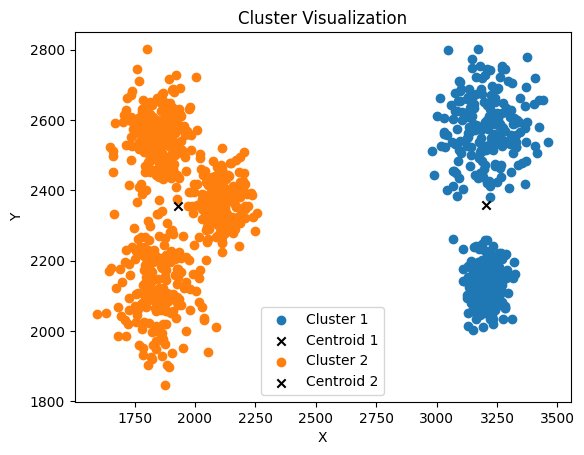

(59970228.48502391,
 406799396.0793503,
 0.7678397057752484,
 [array([3204.11311054, 2359.28791774]),
  array([1928.50081833, 2355.99181669])])

In [ ]:
# Running K-means for k=2, Run # 1
k = 2
run=1
ds1 = sc.textFile('DS1.txt').map(lambda x: x) #Reading DS1
ds1 = ds1.map(lambda x: parseVector(x)).cache()
runKMEAN(ds1,k,run)

Running K Means for k= 2 Run #  2
Updated Centres :
 [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  35846847.7086743
Cluster  2 : WSSE:  24123380.77634961
BSSE = 406799396.0793503
SC: 0.7678397057752484

Time Taken to Converge: 1.7526657581329346 seconds

Iterations Required to Converge: 3


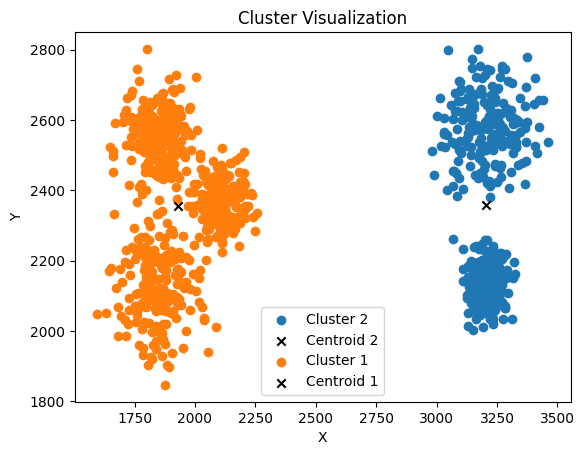

(59970228.48502391,
 406799396.0793503,
 0.7678397057752484,
 [array([1928.50081833, 2355.99181669]),
  array([3204.11311054, 2359.28791774])])

In [ ]:
# Running K-means for k=2, Run # 2
k = 2
run=2
ds1 = sc.textFile('DS1.txt').map(lambda x: x) #Reading DS1
ds1 = ds1.map(lambda x: parseVector(x)).cache()
runKMEAN(ds1,k,run)

Running K Means for k= 3 Run #  1
Updated Centres :
 [array([3203.57068063, 2131.4921466 ]), array([3204.63636364, 2579.03030303]), array([1928.50081833, 2355.99181669])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  1014080.5340314135
Cluster  3 : WSSE:  35846847.7086743
Cluster  2 : WSSE:  3637255.6363636362
BSSE = 531675448.62554723
SC: 0.8358596538337197

Time Taken to Converge: 2.2867202758789062 seconds

Iterations Required to Converge: 4


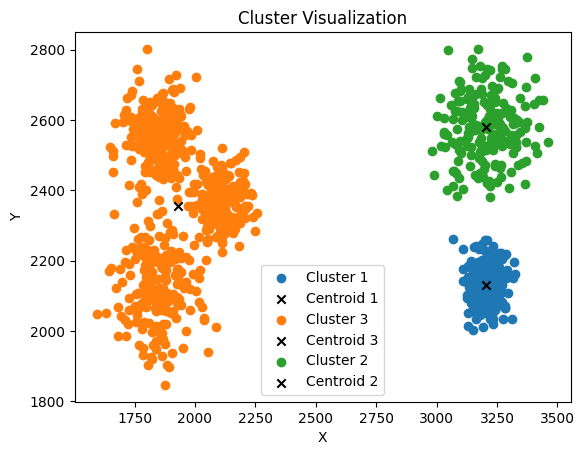

(40498183.87906934,
 531675448.62554723,
 0.8358596538337197,
 [array([3203.57068063, 2131.4921466 ]),
  array([3204.63636364, 2579.03030303]),
  array([1928.50081833, 2355.99181669])])

In [ ]:
# Running K-means for k=3, Run # 1
k = 3
run=1
ds1 = sc.textFile('DS1.txt').map(lambda x: x) #Reading DS1
ds1 = ds1.map(lambda x: parseVector(x)).cache()
runKMEAN(ds1,k,run)

Running K Means for k= 3 Run #  2
Updated Centres :
 [array([1975.68134715, 2240.44041451]), array([3204.11311054, 2359.28791774]), array([1847.56      , 2554.22666667])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  16900866.93523316
Cluster  3 : WSSE:  2616916.88
Cluster  2 : WSSE:  24123380.77634961
BSSE = 410596416.37526965
SC: 0.7864128816231716

Time Taken to Converge: 2.4949705600738525 seconds

Iterations Required to Converge: 4


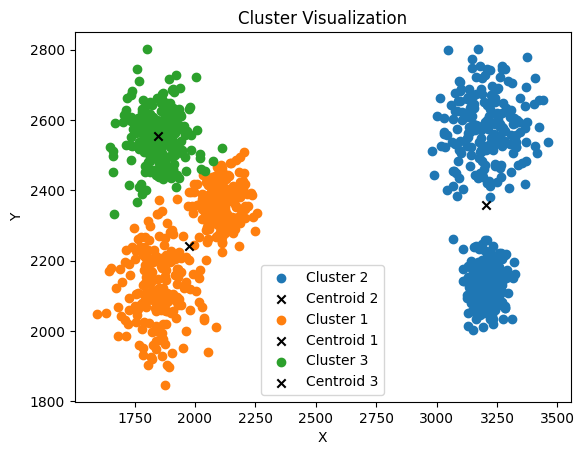

(43641164.591582775,
 410596416.37526965,
 0.7864128816231716,
 [array([1975.68134715, 2240.44041451]),
  array([3204.11311054, 2359.28791774]),
  array([1847.56      , 2554.22666667])])

In [ ]:
# Running K-means for k=3, Run # 2
k = 3
run=2
ds1 = sc.textFile('DS1.txt').map(lambda x: x) #Reading DS1
ds1 = ds1.map(lambda x: parseVector(x)).cache()
runKMEAN(ds1,k,run)

Running K Means for k= 4 Run #  1
Updated Centres :
 [array([3209.14655172, 2517.26724138]), array([1928.50081833, 2355.99181669]), array([3203.57068063, 2131.4921466 ]), array([3198.25609756, 2666.40243902])]

Error in each cluster:
WSSE =
Cluster  3 : WSSE:  1014080.5340314135
Cluster  1 : WSSE:  1557467.2241379314
Cluster  2 : WSSE:  35846847.7086743
Cluster  4 : WSSE:  1005609.3414634147
BSSE = 622701110.2269468
SC: 0.8309420421493645

Time Taken to Converge: 3.7237966060638428 seconds

Iterations Required to Converge: 6


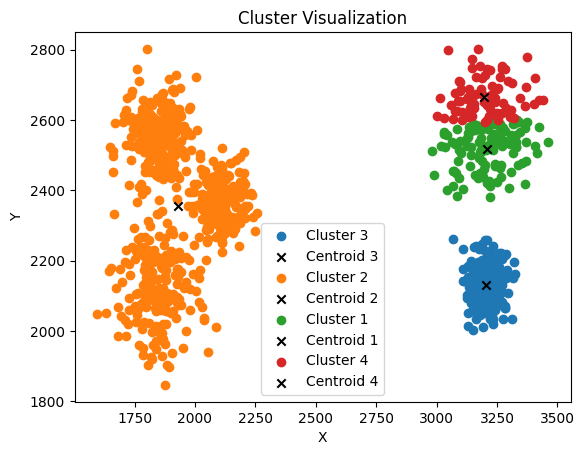

(39424004.80830706,
 622701110.2269468,
 0.8309420421493645,
 [array([3209.14655172, 2517.26724138]),
  array([1928.50081833, 2355.99181669]),
  array([3203.57068063, 2131.4921466 ]),
  array([3198.25609756, 2666.40243902])])

In [ ]:
# Running K-means for k=4, Run # 1
k = 4
run=1
ds1 = sc.textFile('DS1.txt').map(lambda x: x) #Reading DS1
ds1 = ds1.map(lambda x: parseVector(x)).cache()
runKMEAN(ds1,k,run)

Running K Means for k= 4 Run #  2
Updated Centres :
 [array([1975.68134715, 2240.44041451]), array([3204.63636364, 2579.03030303]), array([1847.56      , 2554.22666667]), array([3203.57068063, 2131.4921466 ])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  16900866.93523316
Cluster  3 : WSSE:  2616916.88
Cluster  4 : WSSE:  1014080.5340314135
Cluster  2 : WSSE:  3637255.6363636362
BSSE = 440642108.193802
SC: 0.8574974235626869

Time Taken to Converge: 5.285777807235718 seconds

Iterations Required to Converge: 6


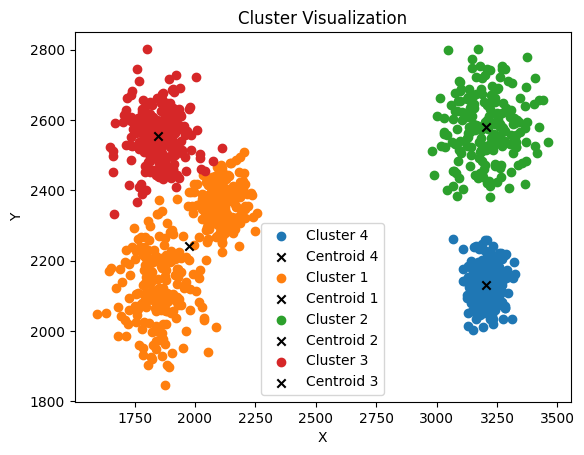

(24169119.98562821,
 440642108.193802,
 0.8574974235626869,
 [array([1975.68134715, 2240.44041451]),
  array([3204.63636364, 2579.03030303]),
  array([1847.56      , 2554.22666667]),
  array([3203.57068063, 2131.4921466 ])])

In [ ]:
# Running K-means for k=4, Run # 2
k = 4
run=2
ds1 = sc.textFile('DS1.txt').map(lambda x: x) #Reading DS1
ds1 = ds1.map(lambda x: parseVector(x)).cache()
runKMEAN(ds1,k,run)

2. Perform BISECTING Kmeans Clustering using your own Pyspark code on dataset DS1.  
a. Run BISECTING Kmeans for different values of K.  
i. For each value of K, run K-means multiple times.   
ii. Report your findings (error in each clustering, the time required, K that gives the best result)  
b. Examine the quality of clusters and also of clusterings.  
i. Report the errors: within-cluster sum of squared error (WSSE), between-cluster sum of the square
error (BSSE), and silhouette coefficient (SC) for each run of K-mean. Write your PySPARK code to
calculate BSSE, WSSE, and SC.

Running K Means for k= 2 Run #  1
Updated Centres :
 [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  35846847.7086743
Cluster  2 : WSSE:  24123380.77634961
BSSE = 406799396.0793503
SC: 0.7678397057752484

Time Taken to Converge: 3.965717077255249 seconds

Iterations Required to Converge: 5


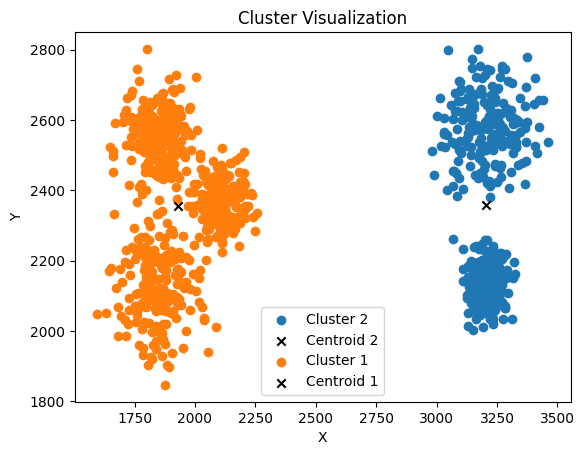

Running K Means for k= 2 Run #  2
Updated Centres :
 [array([3204.11311054, 2359.28791774]), array([1928.50081833, 2355.99181669])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  24123380.77634961
Cluster  2 : WSSE:  35846847.7086743
BSSE = 406799396.0793503
SC: 0.7678397057752484

Time Taken to Converge: 1.2012474536895752 seconds

Iterations Required to Converge: 2


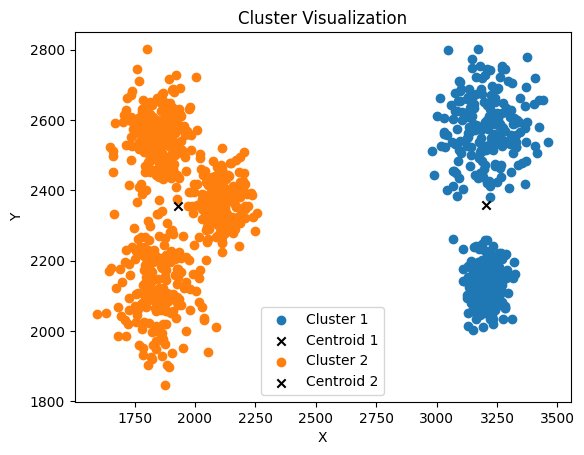

Running K Means for k= 2 Run #  3
Updated Centres :
 [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  35846847.7086743
Cluster  2 : WSSE:  24123380.77634961
BSSE = 406799396.0793503
SC: 0.7678397057752484

Time Taken to Converge: 4.039341688156128 seconds

Iterations Required to Converge: 4


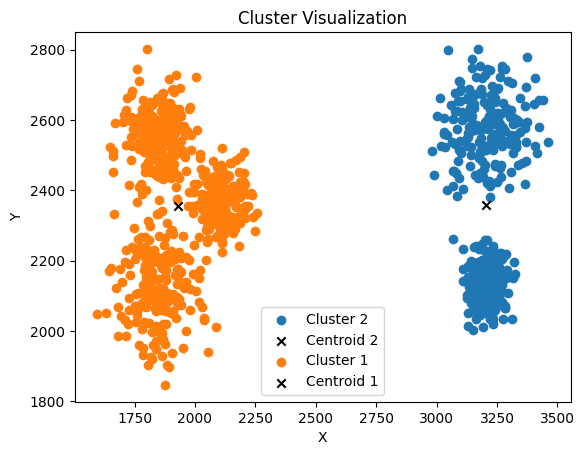

Running K Means for k= 2 Run #  4
Updated Centres :
 [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  35846847.7086743
Cluster  2 : WSSE:  24123380.77634961
BSSE = 406799396.0793503
SC: 0.7678397057752484

Time Taken to Converge: 2.082462787628174 seconds

Iterations Required to Converge: 3


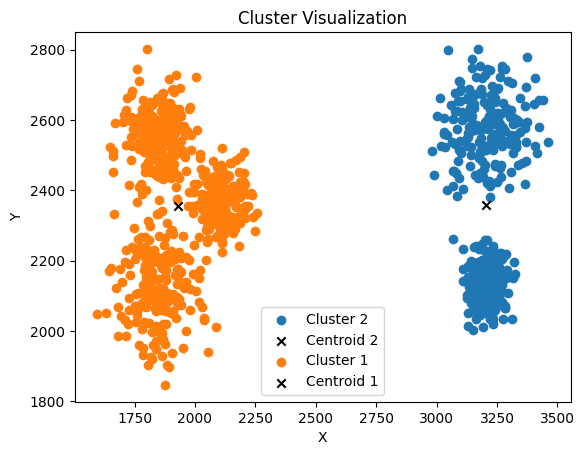

Running K Means for k= 2 Run #  5
Updated Centres :
 [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  35846847.7086743
Cluster  2 : WSSE:  24123380.77634961
BSSE = 406799396.0793503
SC: 0.7678397057752484

Time Taken to Converge: 1.1772358417510986 seconds

Iterations Required to Converge: 2


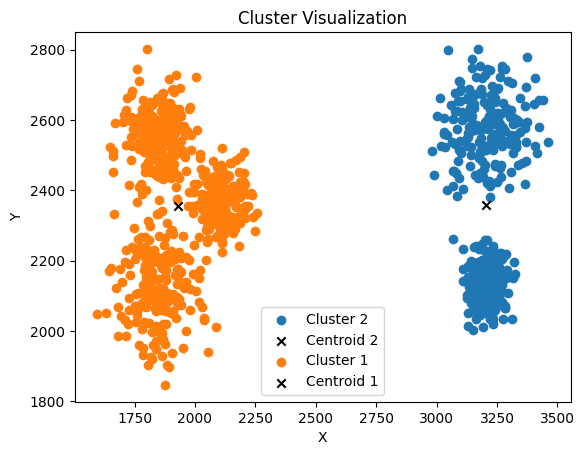

Running K Means for k= 2 Run #  6
Updated Centres :
 [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]

Error in each cluster:
WSSE =
Cluster  1 : WSSE:  35846847.7086743
Cluster  2 : WSSE:  24123380.77634961
BSSE = 406799396.0793503
SC: 0.7678397057752484

Time Taken to Converge: 1.5785486698150635 seconds

Iterations Required to Converge: 2


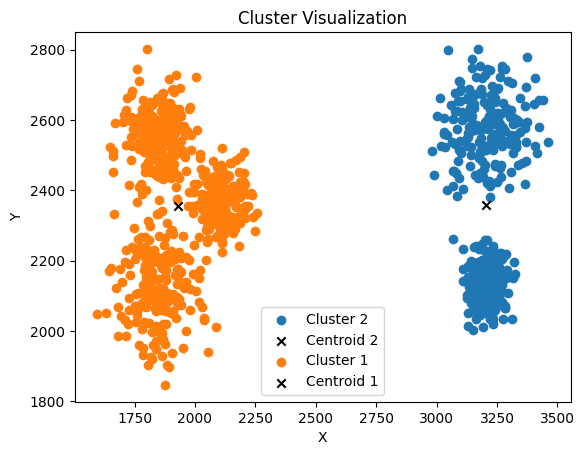

Cluster 1 Centroid: [array([3204.11311054, 2359.28791774]), array([1928.50081833, 2355.99181669])]
Cluster 2 Centroid: [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]
Cluster 3 Centroid: [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]


In [ ]:
def runKMEAN(ds1,k,run):
  print('Running K Means for k=',k,'Run # ',run)
  # Step 1: Find k random center points from Dataset
  kPoints = ds1.takeSample(withReplacement=False, num=k)
  tempDistance = 1.0
  convergeDistance = float(0.1)
  iterations=0
  start=time.time()
  while tempDistance > convergeDistance:
      closest = ds1.map(lambda p: (closestPoint(p, kPoints), (p, 1)))  # Assign Nearest Cluster to each Point
      closestFound2 = closest.reduceByKey(lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1]))  # Sum points and their count in each cluster
      newPoints = closestFound2.map(lambda point: (point[0], point[1][0] / point[1][1])).collect()  # Find avg of points in each cluster
      # Now finding distance between new cluster centers and old ones
      tempDistance = 0.0
      for (ik, p) in newPoints:
          tempDistance += np.sum((kPoints[ik] - p)**2)

      # Assigning new clusters their values
      for (ik, p) in newPoints:
          kPoints[ik] = p

      iterations=iterations+1

  end=time.time()
  timeTaken=end-start
  print('Updated Centres :\n',kPoints)
  print('\nError in each cluster:')
  wsse=getWSSE(kPoints,ds1) #within-cluster sum of squared error (WSSE)
  bsse=getBSSE(kPoints,ds1) #between-cluster sum of the square error (BSSE)
  sc=getSC(kPoints,ds1) #silhouette coefficient (SC)
  print('\nTime Taken to Converge:',timeTaken,'seconds')
  print('\nIterations Required to Converge:',iterations)
  #Visualizing final clusters
  visualizeAns(kPoints, ds1)
  return wsse,bsse,sc,kPoints

def visualizeAns(kPoints, ds1): #To Visualize clusters and centroids
    clusters = ds1.map(lambda p: (closestPoint(p, kPoints), p)).collect()

    # Separating points by cluster and creating a dictionary to store it
    clusterPoints = {}
    for cluster, point in clusters:
        if cluster not in clusterPoints:
            clusterPoints[cluster] = []
        clusterPoints[cluster].append(point)

    # Plot clusters and centroids
    for cluster, points in clusterPoints.items():
        points = np.array(points)
        centroid = kPoints[cluster]
        plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster+1}')
        plt.scatter(centroid[0], centroid[1], color='black', marker='x', label=f'Centroid {cluster+1}')

    plt.title('Cluster Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

def bisectKmeans(ds1, k, max_iterations=5):
    # Initialize the list to hold the final clusters
    finalClusters = []

    # Initially, consider all data points as one cluster
    currentClusters = [ds1.collect()]
    ith=1
    for _ in range(k - 1):  # Repeat the process k - 1 times to get k clusters
        worstSSEClusterIndex = None
        worstSSEClusterScore = float('inf')

        #Finding the cluster to bisect
        for i, cluster in enumerate(currentClusters):
            # Split it into two
            wsse, _, _, _ = runKMEAN(sc.parallelize(cluster), 2, ith)

            # Checking if WSSSE is the smallest so far
            if wsse < worstSSEClusterScore:
                worstSSEClusterScore = wsse
                worstSSEClusterIndex = i
        ith=ith+1
        # Bisecting that cluster found
        worstSSECluster = currentClusters.pop(worstSSEClusterIndex)
        _, _, _, kPoints = runKMEAN(sc.parallelize(worstSSECluster), 2, ith)
        # Updating  list of current clusters
        finalClusters.append(kPoints)              # Appending results of the bisected clusters
        currentClusters.extend([worstSSECluster])  # Appending new clusters for further bisecting
        ith=ith+1

    return finalClusters

k = 4
maxIterations = 5   # Maximum number of iterations for regular k-means
finalClusters = bisectKmeans(ds1, k, maxIterations)

# Final clusters  ---------->
for i, centroid in enumerate(finalClusters):
    print(f'Cluster {i + 1} Centroid: {centroid}')

3. Perform K-MEANS clustering using PYSPARK MLLIB Kmeans function on the given dataset DS2, DS3.  
a. Use the Silhouette method to find the optimal value of K.  
i. Run K-means multiple times for optimal K. Report your findings (error in each clustering, the time
required, the number of iterations to convergence for different runs.)  
ii. Report the errors: within-cluster sum of squared error (WSSE), between-cluster sum of the square
error (BSSE), and silhouette coefficient (SC) for each run of K-mean. Use PYSPARK MLLIB library for
calculating BSSE, WSSE, and SC.  
b. RUN Kmeans with K greater than the optimal K and post-process to improve the clustering results. Post-
processing can help when clusters are of different sizes, densities, or shapes.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time


# Step # 1 : Read Data ------------------>
DS1 = spark.read.text('DS1.txt')
DS2 = spark.read.text('DS2.txt')

# Step # 2 : Preprocess Data ------------------>
def preprocess(data): # This function will parse and assemble features in data
    parsed = data.rdd.map(lambda row: [float(x) for x in row.value.split(' ')]).toDF(["X", "Y"])
    assembler = VectorAssembler(inputCols=["X", "Y"], outputCol="features")
    assembled = assembler.transform(parsed)
    return assembled
# Preprocessing DS1 and DS2
preprocessedDS1= preprocess(DS1)
preprocessedDS2 = preprocess(DS2)

#Step # 3 : Run K Means Mulitple Times to find best value of K ------------------->
def getBestK(data):
    allKs = range(2, 5)       # Ks to run are k =2,3,4
    bestK = None              # Initializing value of best K with none
    bestSilhouette = -1       # Initializing value of best Silhouette with -1
    bestWsse = float('inf')   # Initializing value of best Wsse with positive infinity

    for k in allKs:
        kmeans = KMeans(k=k, seed=1)         # First Defining KMeans model with seed =1 for reproducibility purposes
        model = kmeans.fit(data)             # Fitting the model
        predictions = model.transform(data)  # Making predictions on the data

        # Evaluate clustering by computing Silhouette score
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)

        # Calculating WSSE (Within-Cluster Sum of Squared Error)
        wsse = model.summary.trainingCost

        # Calculating BSSE (Between-Cluster Sum of Squared Error)
        clusterCenters = model.clusterCenters()
        bsse = calculateBsse(clusterCenters)

        print(f"Silhouette score for K={k}: {silhouette}, WSSE: {wsse}, BSSE: {bsse}")

        if silhouette > bestSilhouette: #Update bestK, best Silhouette & bestWsse only if current silhouette is greater than best silhouette
            bestK = k
            bestSilhouette = silhouette
            bestWsse = wsse

    print(f"Optimal K: {bestK}, Silhouette Score: {bestSilhouette}, Best WSSE: {bestWsse}")
    return bestK

# Function to Calculating BSSE
def calculateBsse(clusterCenters):
    bsse = 0.0
    num = len(clusterCenters)

    for i in range(num):
        for j in range(num):
          if(i!=j):
            centeri = clusterCenters[i]
            centerj = clusterCenters[j]
            squaredDist = np.sum((centeri - centerj) ** 2)
            bsse = bsse + squaredDist

    return bsse

# Finding out the best value of K for DS2 and DS3
bestk1=getBestK(preprocessedDS1)
bestk2=getBestK(preprocessedDS2)

Silhouette score for K=2: 0.9300334351025269, WSSE: 59970228.48502394, BSSE: 3254395.168634804
Silhouette score for K=3: 0.9076503023053574, WSSE: 40498183.87906939, BSSE: 7109525.778275301
Silhouette score for K=4: 0.8381558342151313, WSSE: 39183996.01079804, BSSE: 10991742.558920657
Optimal K: 2, Silhouette Score: 0.9300334351025269, Best WSSE: 59970228.48502394
Silhouette score for K=2: 0.977689319886371, WSSE: 7011360115400.669, BSSE: 192494316366.1994
Silhouette score for K=3: 0.9429828430500716, WSSE: 6164096499747.533, BSSE: 397700954255.82446
Silhouette score for K=4: 0.707571350834473, WSSE: 3404478608094.0596, BSSE: 948884433265.5885
Optimal K: 2, Silhouette Score: 0.977689319886371, Best WSSE: 7011360115400.669


**Post Processing**

In [ ]:
from pyspark.sql.functions import col
# Function to perform post-processing on the clusters
def postProcessClusters(model, predictions, minCsize=10, maxCsse=1000, mergeThreshold=0.5):
    # Filter out clusters with high SSE
    modelSummary = model.summary
    clusterSizes = modelSummary.clusterSizes
    looseClusters = [i for i, size in enumerate(clusterSizes) if size >= maxCsse]

    # Filtering out loose clusters from predictions
    filteredPredictions = predictions.filter(~col("prediction").isin(looseClusters))

    return filteredPredictions
# After finding the best k for each dataset
# Fitting KMeans models with the optimal k values
kmeans1 = KMeans(k=bestk1, seed=1)
model1 = kmeans1.fit(preprocessedDS1)
predictions1 = model1.transform(preprocessedDS1)

kmeans2 = KMeans(k=bestk2, seed=1)
model2 = kmeans2.fit(preprocessedDS2)
predictions2 = model2.transform(preprocessedDS2)

# Performing post-processing on the predictions
predictions1 = postProcessClusters(model1, predictions1)
predictions2 = postProcessClusters(model2, predictions2)


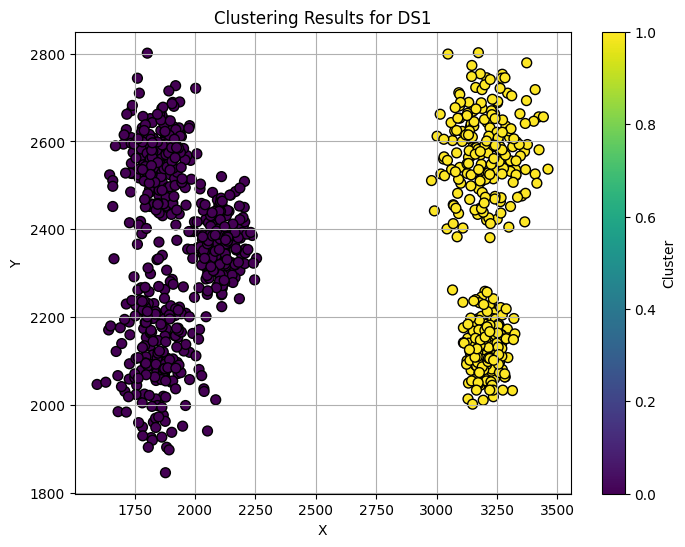

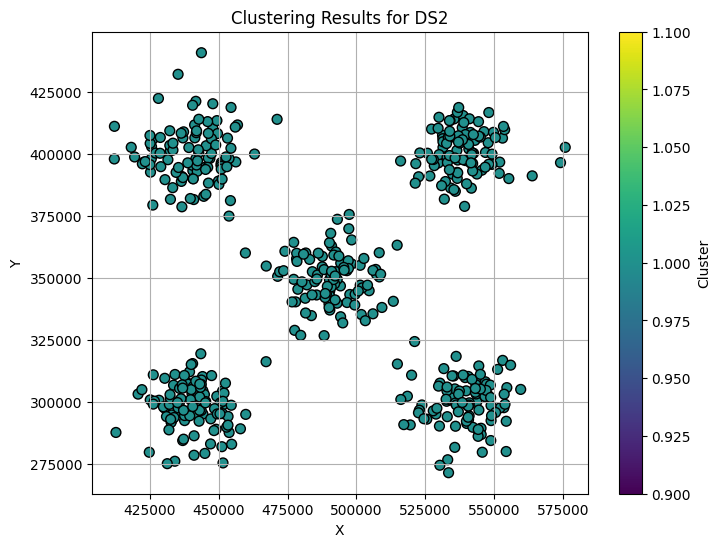

In [ ]:
import matplotlib.pyplot as plt

def plotClusters(predictions, title):
    # Extract X and Y coordinates
    X = predictions.select("X").rdd.flatMap(lambda x: x).collect()
    Y = predictions.select("Y").rdd.flatMap(lambda x: x).collect()
    cluster_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X, Y, c=cluster_labels, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()

# Plot clusters for DS1
plotClusters(predictions1, 'Clustering Results for DS1')

# Plot clusters for DS2
plotClusters(predictions2, 'Clustering Results for DS2')


4. Repeat using the Bisecting Kmeans clustering function provided in PYSPARK MLLIB:  
Perform K-MEANS clustering using PYSPARK MLLIB Kmeans function on the given dataset DS2, DS3.
a. Use the Silhouette method to find the optimal value of K.
i. Run K-means multiple times for optimal K. Report your findings (error in each clustering, the time
required, the number of iterations to convergence for different runs.)
ii. Report the errors: within-cluster sum of squared error (WSSE), between-cluster sum of the square
error (BSSE), and silhouette coefficient (SC) for each run of K-mean. Use PYSPARK MLLIB library for
calculating BSSE, WSSE, and SC.

b. RUN Kmeans with K greater than the optimal K and post-process to improve the clustering results. Post-
processing can help when clusters are of different sizes, densities, or shapes.



/usr/local/lib/python3.10/dist-packages/pyspark/ml/clustering.py:1016: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  warnings.warn(


Silhouette score for K=2: 0.9300334351025269, WSSE: 59970228.48502394, BSSE: 3254395.168634804
Silhouette score for K=3: 0.759066658536799, WSSE: 41954375.7563119, BSSE: 7165062.506195096
Silhouette score for K=4: 0.561342256722003, WSSE: 31027111.544380452, BSSE: 13331501.010269053
Optimal K: 2, Silhouette Score: 0.9300334351025269, Best WSSE: 59970228.48502394
Silhouette score for K=2: 0.977689319886371, WSSE: 7011360115400.669, BSSE: 192494316366.1994
Silhouette score for K=3: 0.7460287620725604, WSSE: 4022682726386.8555, BSSE: 410339859919.4301
Silhouette score for K=4: 0.7189355963485206, WSSE: 3131880783349.231, BSSE: 844894681962.0858
Optimal K: 2, Silhouette Score: 0.977689319886371, Best WSSE: 7011360115400.669


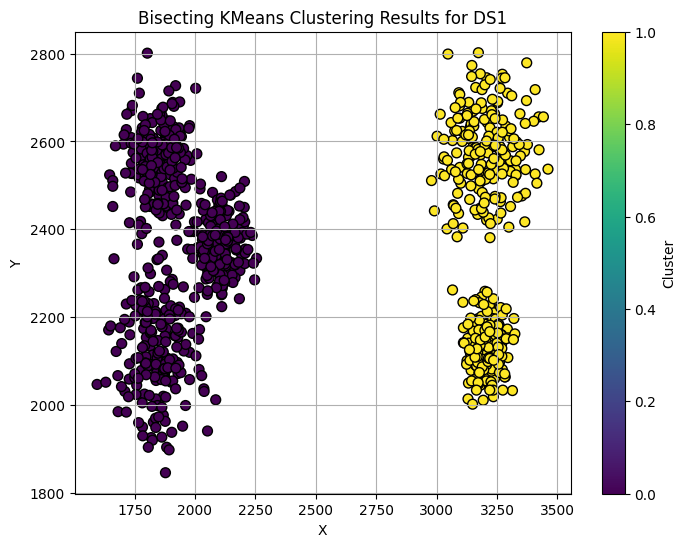

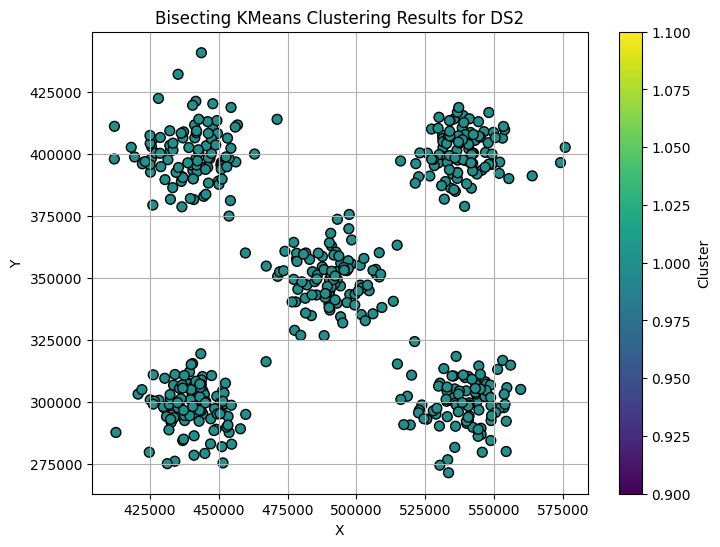

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import ClusteringEvaluator
import time


# Step # 1: Read Data
DS1 = spark.read.text('DS1.txt')
DS2 = spark.read.text('DS2.txt')

# Step # 2: Preprocess Data
def preprocess(data):
    parsed = data.rdd.map(lambda row: [float(x) for x in row.value.split(' ')]).toDF(["X", "Y"])
    assembler = VectorAssembler(inputCols=["X", "Y"], outputCol="features")
    assembled = assembler.transform(parsed)
    return assembled

# Preprocessing DS1 and DS2
preprocessedDS1 = preprocess(DS1)
preprocessedDS2 = preprocess(DS2)

# Step # 3: Run Bisecting KMeans Multiple Times to Find the Best Value of K
def getBestBisectingK(data):
    allKs = range(2, 5)  # Ks to run are k = 2, 3, 4
    bestK = None  # Initializing value of best K with none
    bestSilhouette = -1  # Initializing value of best Silhouette with -1
    bestWsse = float('inf')  # Initializing value of best Wsse with positive infinity

    for k in allKs:
        bkmeans = BisectingKMeans(k=k, seed=1)  # Define Bisecting KMeans model
        model = bkmeans.fit(data)  # Fit the model
        predictions = model.transform(data)  # Make predictions on the data

        # Calculate Silhouette score
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)

        # Calculate WSSE (Within-Cluster Sum of Squared Error)
        wsse = model.computeCost(data)
        # Calculating BSSE (Between-Cluster Sum of Squared Error)
        clusterCenters = model.clusterCenters()
        bsse = calculateBsse(clusterCenters)
        print(f"Silhouette score for K={k}: {silhouette}, WSSE: {wsse}, BSSE: {bsse}")


        if silhouette > bestSilhouette:  # Update bestK and best Silhouette if current silhouette is greater than best silhouette
            bestK = k
            bestSilhouette = silhouette
            bestWsse = wsse

    print(f"Optimal K: {bestK}, Silhouette Score: {bestSilhouette}, Best WSSE: {bestWsse}")
    return bestK
# Function to Calculating BSSE
def calculateBsse(clusterCenters):
    bsse = 0.0
    num = len(clusterCenters)

    for i in range(num):
        for j in range(num):
          if(i!=j):
            centeri = clusterCenters[i]
            centerj = clusterCenters[j]
            squaredDist = np.sum((centeri - centerj) ** 2)
            bsse = bsse + squaredDist

    return bsse
# Function to visualize the clustering results
def plotCbisecting(predictions, title):
    X = predictions.select("X").rdd.flatMap(lambda x: x).collect()
    Y = predictions.select("Y").rdd.flatMap(lambda x: x).collect()
    cluster_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

    plt.figure(figsize=(8, 6))
    plt.scatter(X, Y, c=cluster_labels, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()

# Function for post-processing clusters
def postProcessClusters(model, predictions, minCsize=10, maxCsse=1000, mergeThreshold=0.5):
    # Filter out clusters with high SSE
    modelSummary = model.summary
    clusterSizes = modelSummary.clusterSizes
    looseClusters = [i for i, size in enumerate(clusterSizes) if size >= maxCsse]

    # Filtering out loose clusters from predictions
    filteredPredictions = predictions.filter(~col("prediction").isin(looseClusters))

    return filteredPredictions

# Finding the best value of K for DS1 and DS2 using Bisecting KMeans
bestk1Bisecting = getBestBisectingK(preprocessedDS1)
bestk2Bisecting = getBestBisectingK(preprocessedDS2)

# Plotting clusters for DS1 using Bisecting KMeans
bkmeans1 = BisectingKMeans(k=bestk1Bisecting, seed=1)
model1Bisecting = bkmeans1.fit(preprocessedDS1)
predictions1Bisecting = model1Bisecting.transform(preprocessedDS1)
filteredPredictions1 = postProcessClusters(model1Bisecting, predictions1Bisecting)
plotCbisecting(filteredPredictions1, 'Bisecting KMeans Clustering Results for DS1')

# Plotting clusters for DS2 using Bisecting KMeans
bkmeans2 = BisectingKMeans(k=bestk2Bisecting, seed=1)
model2Bisecting = bkmeans2.fit(preprocessedDS2)
predictions2Bisecting = model2Bisecting.transform(preprocessedDS2)
filteredPredictions2 = postProcessClusters(model2Bisecting, predictions2Bisecting)
plotCbisecting(filteredPredictions2, 'Bisecting KMeans Clustering Results for DS2')